# The Bayesian framework using minimization of weights

## Simulated data

In [309]:
from scipy import optimize
from scipy.interpolate import interp1d
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pdb

# load the filename list
#fns = glob.glob('../../Data/LUT/lhd300_validate_ap/20/30/45/*.p')
fns = ['../../Data/LUT/lhd1000_valid_ap_realistic/40_54_52_1.85958871_0.15750657_26.89028313_1022.28958805_0.32186472_0.591295.p']

print 'loading file: %s' % fns[0]

wl_min = 680.
wl_max = 755.


loading file: ../../Data/LUT/lhd1000_valid_ap_realistic/40_54_52_1.85958871_0.15750657_26.89028313_1022.28958805_0.32186472_0.591295.p


solver success: True
cost: 82.9965
sza: 40.0, vza: 54.0, raa: 52.0, alt: 1.85958871 km
--------------------------------------------------
True parameters
clf: 0.1000, AOT: 0.1575, WVC: 26.8903 kg/m2, press: 1022.2896 hPa, a: 0.3219, p: 0.5913, DASF: 0.7875
--------------------------------------------------
Prior parameters (mean, std)
clf: 0.0800, AOT: 0.1700, WVC: 28.0000 kg/m2, press: 1020.0000 hPa, a: 0.5000, p: 0.5000
std: 0.0200, std: 0.0500, std:  2.2000 kg/m2, std:      2.0000 hPa,std:3.1623,std:3.1623
--------------------------------------------------
Retrieved parameters (mean, std)
clf: 0.0798, AOT: 0.4200, WVC: 28.7231 kg/m2, press: 1023.1453 hPa, a: 0.3513, p: 0.5726, DASF: 0.8220
std: 0.0085, std: 0.0383, std:  0.2052 kg/m2, std:      1.9492 hPa,std:0.0053,std:0.0021
--------------------------------------------------
Correlation matrix
[[ 1.         -0.93820872 -0.01838591 -0.76767357  0.85938109  0.32541993
   0.0414011 ]
 [-0.93820872  1.         -0.08714694  0.82741868 

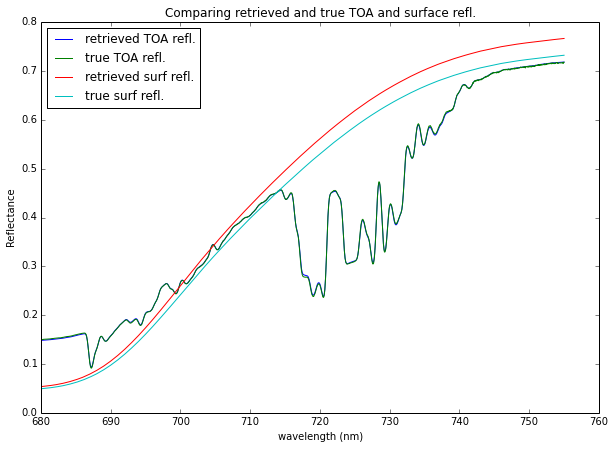

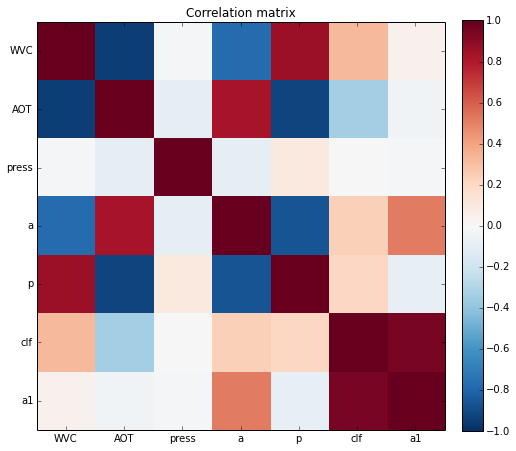

In [330]:
dic = pickle.load(open(fns[0], 'rb'))

# cloud fraction to use
clf = 0.10

# priors variances are based on the following:
# MODIS AOD +-0.05 +-0.02*tau (Chu et al. 2002)
# MODIS WV std 2.2mm (Li, Muller & Cross, 2003)
# NCEP press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)

AOT_prior = 0.17
AOT_var = (0.05)**2
WVC_prior = 28.
WVC_var = (2.2)**2
press_prior = 1020.
press_var = (2.0)**2
clf_prior = 0.08
clf_var = (0.02)**2
a_prior = 0.5
a_var = 10
p_prior = 0.5
p_var = 10
a1_prior = -30
a1_var = 10

# round to closest value
sza = dic['sol_zen']
vza = dic['sat_zen']
raa = dic['rel_azi']
alt = dic['alt']
AOT = dic['AOT']
WVC = dic['WVC']
press = dic['press']
a = dic['a']
p = dic['p']
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))
toa_refl = dic['toa_refl']
lam = dic['lam']
lam_emu = lam[np.logical_and(lam>=wl_min, lam<=wl_max)]

# adding clouds
import pandas as pd
fn = 'cloud_sims.h5'
cld_type = 'Cu'
cld_df = pd.read_hdf(fn, key='reflectance')
cld_lam = cld_df[cld_type].icol(0).index.values
cld_ref = cld_df[cld_type].icol(0).values
cld_ref = cld_ref[np.logical_and(cld_lam>=wl_min, cld_lam<=wl_max)]

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources above
std_noise = cld_ref / snr
rand_noise = np.random.normal(0., std_noise)
cld_ref += rand_noise

# refl to gome
toa_refl_gome = toa_refl[np.logical_and(lam>=wl_min, lam<=wl_max)]
std_noise = toa_refl_gome / snr
rand_noise = np.random.normal(0., std_noise)
toa_refl_gome += rand_noise

# combine atmosphere and cloud signal
toa_refl_gome = toa_refl_gome * (1. - clf) + cld_ref * clf

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas = pca_red_df.values.T

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators_680-755.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
basis = emu.basis_functions

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]
mean_toa_refl = mean_toa_refl[np.logical_and(lam>=wl_min, lam<=wl_max)]

# get prior for observation weights
# wt_priors = np.dot(basis, (toa_refl_gome - mean_toa_refl))

def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
         presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
    '''The cost function to minimize the log of the probabilities
    '''
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    clf = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] # + mean_toa_refl
    # get refls to same wavelenghts
    from scipy.interpolate import interp1d
    # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
    # also subtract mean spectra in training data (see notes on 13/12/15)
    toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
    # calculate weights of the model and observation
    w = []
    m = []
    for i in range(emu.n_pcs):
        w.append(np.dot(toa_refl_comp, basis[i]))
        m.append(np.dot(toa_refl_emu, basis[i]))
    w = np.array(w)
    m = np.array(m)
    # forward model J term. need to calculate variance of the weights
    modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
              for i in range(emu.n_pcs)]
    modvar = np.array(modvar)
    Jmod = 0.5*np.dot((w - m)**2, 1./modvar)
    # WVC J term
    Jwvc = 0.5*(WVC - WVCe)**2./WVCv
    # AOT J term
    Jaot = 0.5*(AOT - AOTe)**2./AOTv
    # press J term
    Jpress = 0.5*(press - presse)**2./pressv
    # a J term
    Ja = 0.5*(a - ae)**2./av
    # p J term
    Jp = 0.5*(p - pe)**2./pv
    # clf J term
    Jclf = 0.5*(clf - clfe)**2./clfv
    # a1 J term
    Ja1 = 0.5*(a1 - a1e)**2./a1v
    J = Jmod + Jwvc + Jaot + Jpress + Ja + Jp + Jclf + Ja1
    
    return J


# def jacob(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
#          presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
#     '''The jacobian of the cost function to minimize the log of the probabilities
#     '''
#     WVC = paras[0]
#     AOT = paras[1]
#     press = paras[2]
#     a = paras[3]
#     p = paras[4]
#     clf = paras[5]
#     a1 = paras[6]
#     paras = (WVC, AOT, alt, press, a, p)
#     toa_refl_emu, Mprime = emu.predict(paras) # + mean_toa_refl
#     # get refls to same wavelenghts
#     from scipy.interpolate import interp1d
#     # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
#     # also subtract mean spectra in training data (see notes on 13/12/15)
# #     toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
# #     # calculate weights of the model and observation
# #     w = []
# #     m = []
# #     for i in range(emu.n_pcs):
# #         w.append(np.dot(toa_refl_comp, basis[i]))
# #         m.append(np.dot(toa_refl_emu, basis[i]))
# #     w = np.array(w)
# #     m = np.array(m)
# #     # forward model jacobian. need to calculate variance of the weights
# #     modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
# #               for i in range(emu.n_pcs)]
# #     modvar = np.array(modvar)
# #     jmod = np.dot((w - m), 1./modvar)
    
#     # obs jacobian
#     jobs = Mprime.dot(basis.T)
#     jobs = np.sum(jobs, axis=1)
    
#     # WVC jacobian
#     jwvc = (WVC - WVCe)/WVCv + jobs[0]
#     # AOT jacobian
#     jaot = (AOT - AOTe)/AOTv + jobs[1]
#     # press jacobian
#     jpress = (press - presse)/pressv + jobs[3]
#     # a jacobian
#     ja = (a - ae)/av + jobs[4]
#     # p jacobian
#     jp = (p - pe)/pv + jobs[5]
#     # clf jacobian
#     jclf = (clf - clfe)/clfv
#     # a1 jacobian
#     ja1 = (a1 - a1e)/a1v

#     return np.array([jwvc, jaot, jpress, ja, jp, jclf, ja1])

# def hess(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
#          presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
#     '''The hessian of the cost function to minimize the log of the probabilities
#     '''
#     WVC = paras[0]
#     AOT = paras[1]
#     press = paras[2]
#     a = paras[3]
#     p = paras[4]
#     clf = paras[5]
#     a1 = paras[6]
#     paras = (WVC, AOT, alt, press, a, p)
#     toa_refl_emu, Mprime = emu.predict(paras) # + mean_toa_refl
#     # get refls to same wavelenghts
#     from scipy.interpolate import interp1d
#     a0 = 1. / (1. - clf)
#     # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
#     # also subtract mean spectra in training data (see notes on 13/12/15)
#     toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
#     # calculate weights of the model and observation
#     w = []
#     m = []
#     for i in range(emu.n_pcs):
#         w.append(np.dot(toa_refl_comp, basis[i]))
#         m.append(np.dot(toa_refl_emu, basis[i]))
#     w = np.array(w)
#     m = np.array(m)
#     # forward model jacobian. need to calculate variance of the weights
#     modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
#               for i in range(emu.n_pcs)]
#     modvar = np.array(modvar)
#     hmod = 1. / modvar
#     # WVC jacobian
#     hwvc = 1./WVCv
#     # AOT jacobian
#     haot = 1./AOTv
#     # press jacobian
#     hpress = 1./pressv
#     # a jacobian
#     ha = 1./av
#     # p jacobian
#     hp = 1./pv
#     # clf jacobian
#     hclf = 1./clfv
#     # a1 jacobian
#     ha1 = 1./a1v
    
#     return np.diag(np.array([hwvc, haot, hpress, ha, hp, hclf, ha1]))
    

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
guess = (WVC_prior, AOT_prior, press_prior, a_prior, p_prior, clf_prior, a1_prior)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (-10000, 0))
lower = (0., 0., 500., 0., 0., 1., -10000)
upper = (80., 1., 1100., 1., 1., 1000., 0.)
solv_paras = optimize.minimize(cost,guess,jac=jacob,method='Nelder-Mead', \
                                args=args,bounds=bounds, options={'maxiter': 5000, 'maxfev': 5000})  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
clfr = solv_paras['x'][5]
a0r = 1. / (1. - clfr)
a1r = solv_paras['x'][6]
err = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda a, p, w: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

import numdifftools as nd
hes = nd.Hessian(cost, full_output=True, method='central')
x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
Cov = np.linalg.inv(H[0])
# calculate the Hessian for the std of the posterior based on analytical method
# can't do this unless we have an emulator that includes the clf, as jacobian of emu has only 6 paras
# H = hess(x, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
#          press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
# Cov = np.linalg.inv(H)
post_std = np.sqrt(np.diag(Cov))
WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

# calculate the correlation matrix
D = np.eye(7)*np.sqrt ( Cov.diagonal() )
R = np.linalg.inv ( D )
corr =  R.dot(Cov.dot(R))

print 'solver success: %s' % succ
print 'cost: %.4f' % err
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'True parameters'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
        (clf, AOT, WVC, press, a, p, dasf_true)
print '-'*50
print 'Prior parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f' % \
        (clf_prior, AOT_prior, WVC_prior, press_prior, a_prior, p_prior)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:%5.4f,std:%5.4f' % \
        (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var), np.sqrt(a_var), np.sqrt(p_var))
print '-'*50
print 'Retrieved parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:%5.4f,std:%5.4f' % \
        (clfs, AOTs, WVCs, presss, ass, ps )
print '-'*50

# plot the spectra true and retrieved
toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl
toa_refl_pred = (1. - clfr)*toa_refl_pred + clfr*a1r*pcas[0]
plt.figure(figsize=(10,7))
plt.plot(lam_emu, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_emu, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(ar, pr, w)
surf_refl = surf_refl_fun(a, p, w)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

# plot the correlation matrix and print values
plt.figure(figsize=(8,8))
plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
plt.title('Correlation matrix')
plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.colorbar(fraction=0.046, pad=0.04)
print 'Correlation matrix'
print corr

## GOME-2 data

In [1]:
# open the pickled dict of observations created before

import sys
import gdal
import os
from scipy import optimize
from scipy.interpolate import interp1d
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import pdb

# to range we need
wl_min = 680
wl_max = 755

# path to EPS file to read
e_fn = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/l1b/2007/01/GOME_xxx_1B_M02_20070125124939Z_20070125143057Z_R_O_20120209112017Z'

path = '/home/malapradej/Documents/PhD_UCL/Data/GOME-2/DASF'
base = os.path.splitext(e_fn)[0]
base = os.path.basename(base)
base = os.path.join(path, base)
ext =  '_EPS_QAd.p'
path = os.path.join(path, base + ext)

dic = pickle.load(open(path, 'rb'))

Lat: -0.8059, Lon: -62.9597
(-62.959685, -0.805949)
solver success: True
cost: 698.9637
sza: 48.575761, vza: 40.125111, raa: 12.094507, alt: 0.039 km
--------------------------------------------------
Prior parameters (mean, std)
clf: 0.1720, AOT: 0.2690, WVC: 50.9100 kg/m2, press: 1005.3796 hPa, a:  0.5000,    p: 0.5000
std: 0.0500, std: 0.1080, std:  6.6600 kg/m2, std:     10.0000 hPa,std: 0.7071,  std: 0.7071
--------------------------------------------------
Retrieved parameters (mean, std)
clf: 0.0728, AOT: 0.0971, WVC: 50.3453 kg/m2, press:  878.6305 hPa, a:   0.0367,   p: 0.8704, DASF: 0.2832
std: 0.0041, std: 0.0183, std:  1.1598 kg/m2, std:      8.1854 hPa,std:  0.0005, std: 0.0009
--------------------------------------------------
Correlation matrix
[[ 1.         -0.52500529 -0.51113775  0.0792106  -0.04004171  0.24891389
   0.03318629]
 [-0.52500529  1.         -0.39243723  0.59778981 -0.37935899 -0.27204083
   0.06040955]
 [-0.51113775 -0.39243723  1.         -0.53280201  0

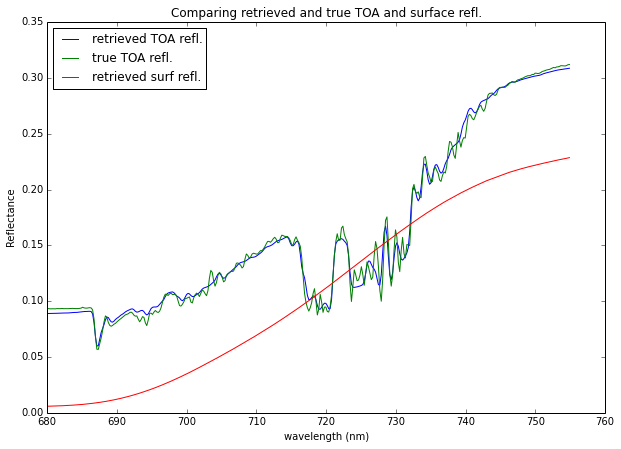

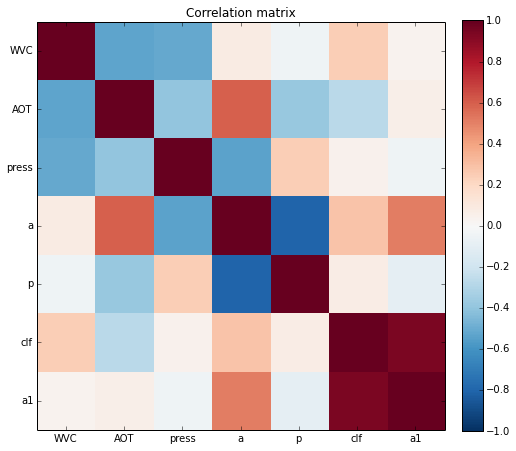

In [22]:
# select sequence number of obs

# select the obs number from this filtered list above
n = 81

# select obs which conform to this less than this clf
clf_thresh = 0.2

ix = np.where(np.array(dic['Cloud_frac']) < clf_thresh)[0]

def raa_fun(sol_azi, sat_azi):
    '''Function to calculate the relative azimuth angle'''
    dif = np.array(sat_azi) - np.array(sol_azi)
    dif = np.where(dif < 0., dif + 360., dif)
    dif = np.where(dif > 180., 360 - dif, dif)
    return dif

i = ix[n]

sza = dic['Sol_zen'][i]
vza = dic['Sat_zen'][i]
sat_azi = dic['Sat_azi'][i]
sol_azi = dic['Sol_azi'][i]
raa = raa_fun(sol_azi, sat_azi)
alt = dic['Alt'][i]/1000. # to km AMSL
toa_refl_gome = dic['Ref_toa'][i]
lam_gome = dic['Lam'][i]
clf_prior = dic['Cloud_frac'][i]

a_prior = 0.5
a_var = 0.5
p_prior = 0.5
p_var = 0.5
a1_prior = -30
a1_var = 10


# load the emulator wavelengths
fns = '../../Data/LUT/lhd1000_valid_ap_realistic/21_15_19_0.50970436_0.07229065_16.37942169_1001.99633933_0.36659157_0.624668.p'
lam_emu = np.arange(680., 755.05, 0.05)#pickle.load(open(fns, 'rb'))['lam']

# print the lat and lon
lat = dic['Lat'][i]
lon = dic['Lon'][i]
print 'Lat: %.4f, Lon: %.4f' % (lat, lon)
print (lon, lat)


# Read in the raster datasets and get values at coordinate
# load SeaWifs AOT 5 year dataset as this is the only one with sufficient data over the Amazon to warrant inclusion
# January is the Amazon wet season which makes observations relatively difficult althoug Burning Aerosols can be 
# expected to be lower. Thus global average will be used in places with no AOD information.
# load ERA-interim WVC and press datasets of the day to start off
# test these first....

#lat, lon = (-1.5, -70.5)

# MODIS AOT daily
fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_day.tiff'

NODATA = -9999

src_ds=gdal.Open(fn)
gt=src_ds.GetGeoTransform()
rb1=src_ds.GetRasterBand(1)
rb2=src_ds.GetRasterBand(2)

px = int((lon - gt[0]) / gt[1]) #x pixel
py = int((lat - gt[3]) / gt[5]) #y pixel

AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]

# MODIS AOT 8 day
if AOT_prior == -9999:
    fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_8_day.tiff'
    
    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    rb2=src_ds.GetRasterBand(2)

    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
    AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]
    
    # MODIS AOT Monthly
    if AOT_prior == -9999:
        fn = '../../Data/MODIS/Combined/MODIS_AOT_combined_grid_Monthly.tiff'

        src_ds=gdal.Open(fn)
        gt=src_ds.GetGeoTransform()
        rb1=src_ds.GetRasterBand(1)
        rb2=src_ds.GetRasterBand(2)

        px = int((lon - gt[0]) / gt[1]) #x pixel
        py = int((lat - gt[3]) / gt[5]) #y pixel

        AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
        AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]
        
        # Monthly average
        if AOT_prior == -9999:
            
            AOT_prior = 0.166
            AOT_var = 0.108

if AOT_var == 0.0:
    AOT_var = 0.108
    
AOT_var = AOT_var**2.


# # SeaWifs AOD
# fn = '../../Data/SeaWIFS/Aerosols/SeaWifs_AOT_combined_5_year.tiff'

# src_ds=gdal.Open(fn)
# gt=src_ds.GetGeoTransform()
# rb1=src_ds.GetRasterBand(1)
# rb2=src_ds.GetRasterBand(2)

# px = int((lon - gt[0]) / gt[1]) #x pixel
# py = int((lat - gt[3]) / gt[5]) #y pixel

# AOT_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
# AOT_var=rb2.ReadAsArray(px,py,1,1)[0][0]**2.

# if np.isnan(AOT_prior):
#     AOT_prior = 0.05
#     AOT_var = 0.03**2.

# MODIS WVC daily
fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_day.tiff'

NODATA = -9999

src_ds=gdal.Open(fn)
gt=src_ds.GetGeoTransform()
rb1=src_ds.GetRasterBand(1)
rb2=src_ds.GetRasterBand(2)

px = int((lon - gt[0]) / gt[1]) #x pixel
py = int((lat - gt[3]) / gt[5]) #y pixel

WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

# MODIS WVC 8 day
if WVC_prior == -9999:
    fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_8_day.tiff'
    
    src_ds=gdal.Open(fn)
    gt=src_ds.GetGeoTransform()
    rb1=src_ds.GetRasterBand(1)
    rb2=src_ds.GetRasterBand(2)

    px = int((lon - gt[0]) / gt[1]) #x pixel
    py = int((lat - gt[3]) / gt[5]) #y pixel

    WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
    WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]
    
    # MODIS WVC Monthly
    if WVC_prior == -9999:
        fn = '../../Data/MODIS/Combined/MODIS_WVC_combined_grid_monthly.tiff'

        src_ds=gdal.Open(fn)
        gt=src_ds.GetGeoTransform()
        rb1=src_ds.GetRasterBand(1)
        rb2=src_ds.GetRasterBand(2)

        px = int((lon - gt[0]) / gt[1]) #x pixel
        py = int((lat - gt[3]) / gt[5]) #y pixel

        WVC_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
        WVC_var=rb2.ReadAsArray(px,py,1,1)[0][0]

        # ERA-Interim press
        if WVC_prior == -9999:
            fn = '../../Data/ERA-Interim/Era_interim_press_wvc.tiff'

            src_ds=gdal.Open(fn)
            gt=src_ds.GetGeoTransform()
            #rb1=src_ds.GetRasterBand(2)
            rb2=src_ds.GetRasterBand(2)

            px = int((lon - gt[0]) / gt[1]) #x pixel
            py = int((lat - gt[3]) / gt[5]) #y pixel

            #press_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
            WVC_prior=rb2.ReadAsArray(px,py,1,1)[0][0]
        
            # Monthly average
            if WVC_prior == -9999:

                WVC_prior = 19.39
                WVC_var = 3.21

WVC_var = WVC_var**2.



# ERA-Interim press
fn = '../../Data/ERA-Interim/Era_interim_press_wvc.tiff'

src_ds=gdal.Open(fn)
gt=src_ds.GetGeoTransform()
rb1=src_ds.GetRasterBand(1)
#rb2=src_ds.GetRasterBand(2)

px = int((lon - gt[0]) / gt[1]) #x pixel
py = int((lat - gt[3]) / gt[5]) #y pixel

press_prior=rb1.ReadAsArray(px,py,1,1)[0][0]
press_var = (10.0)**2

#WVC_prior=rb2.ReadAsArray(px,py,1,1)[0][0]


# priors variances are based on the following:
# MODIS AOD +-0.05 +-0.2*tau (Chu et al. 2002)
# MODIS WV std 2.2mm (Li, Muller & Cross, 2003)
# NCEP and ERA-Interim press unknown...
# FRESCO vs FRESCO+ clf std 0.023 (Tuinder et al 2010) but expected accuracy <10% (Valks et al 2013)


#AOT_prior = 0.13
#AOT_var = (0.04)**2
#WVC_prior = 47.99
#WVC_var = (10.0)**2
#press_prior = 1005.3
press_var = (10.0)**2
# clf_prior = 0.25
clf_var = (0.05)**2

# round to closest value

# AOT = dic['AOT']
# WVC = dic['WVC']
# press = dic['press']
# a = dic['a']
# p = dic['p']
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))

# get gome wavelength interval to correct range
toa_refl_gome = toa_refl_gome[np.logical_and(lam_gome > wl_min, lam_gome < wl_max)]
lam_gome = lam_gome[np.logical_and(lam_gome > wl_min, lam_gome < wl_max)]

# # add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
snr = 1000 # see sources in previous WB

# import cloud PCA
h5_fn = 'cloud_sims.h5'
pca_red_df = pd.read_hdf(h5_fn, key='pca_red_edge')

pca_lam = np.array(pca_red_df.index)
pcas_ = pca_red_df.values.T

# interpolate to gome resolution
pcas = []
for pc in pcas_:
    pcas.append((interp1d(pca_lam, pc, kind='linear'))(lam_gome))
pcas = np.array(pcas)

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators_680-755.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
basis = emu.basis_functions

import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')
grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]
mean_toa_lam = np.arange(540., 800.05, 0.05)
mean_toa_refl_emu = (interp1d(mean_toa_lam, mean_toa_refl,kind='linear'))(lam_emu)
mean_toa_refl = (interp1d(mean_toa_lam, mean_toa_refl,kind='linear'))(lam_gome)


def cost(paras, sza, vza, raa, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVCe, WVCv, AOTe, AOTv,\
         presse, pressv, ae, av, pe, pv, clfe, clfv, a1e, a1v):
    '''The cost function to minimize the log of the probabilities
    '''    
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    clf = paras[5]
    a1 = paras[6]
    paras = (WVC, AOT, alt, press, a, p)
    toa_refl_emu = emu.predict(paras)[0] # + mean_toa_refl
    # get refls to same wavelenghts
    # instead of comparing toa refl including cloud need to subtract cloud influence from gome spectra
    # also subtract mean spectra in training data (see notes on 13/12/15)
    toa_refl_comp = (toa_refl_gome - clf*a1*pcas[0]) / (1. - clf) - mean_toa_refl
    # get reflectance to same wavelenghts as the PCs
    lam_gome_ = np.insert(lam_gome, 0, wl_min)
    lam_gome_ = np.append(lam_gome_, wl_max)
    toa_refl_comp_ = np.insert(toa_refl_comp, 0, toa_refl_comp[0])
    toa_refl_comp_ = np.append(toa_refl_comp_, toa_refl_comp[-1])
    toa_refl_comp = (interp1d(lam_gome_, toa_refl_comp_, kind='linear'))(lam_emu)
    # calculate weights of the model and observation
    w = []
    m = []
    for i in range(emu.n_pcs):
        w.append(np.dot(toa_refl_comp, basis[i]))
        m.append(np.dot(toa_refl_emu, basis[i]))
    w = np.array(w)
    m = np.array(m)
    # forward model J term. need to calculate variance of the weights
    modvar = [np.mean(basis[i]**2*toa_refl_comp**2) - np.mean(basis[i]*toa_refl_comp)**2\
              for i in range(emu.n_pcs)]
    modvar = np.array(modvar)
    Jmod = 0.5*np.dot((w - m)**2, 1./modvar)
    # WVC J term
    Jwvc = 0.5*(WVC - WVCe)**2./WVCv
    # AOT J term
    Jaot = 0.5*(AOT - AOTe)**2./AOTv
    # press J term
    Jpress = 0.5*(press - presse)**2./pressv
    # a J term
    Ja = 0.5*(a - ae)**2./av
    # p J term
    Jp = 0.5*(p - pe)**2./pv
    # clf J term
    Jclf = 0.5*(clf - clfe)**2./clfv
    # a1 J term
    Ja1 = 0.5*(a1 - a1e)**2./a1v
    J = Jmod + Jwvc + Jaot + Jpress + Ja + Jp + Jclf + Ja1
    
    return J

args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
#guess = (36., 0.5, 770., 0.4, 0.4, 1.1, 30.) # wvc, aot, press, a, p, clf, a1
guess = (WVC_prior, AOT_prior, press_prior, a_prior, p_prior, clf_prior, a1_prior)
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.), (0., 1.), (-10000, 0))
lower = (0., 0., 500., 0., 0., 1., -10000)
upper = (80., 1., 1100., 1., 1., 1000., 0.)
solv_paras = optimize.minimize(cost,guess,jac=False,method='Nelder-Mead',\
                                args=args,bounds=bounds, options={'maxiter': 5000, 'maxfev': 5000})  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras['x'][0]
AOTr = solv_paras['x'][1]
pressr = solv_paras['x'][2]
ar = solv_paras['x'][3]
pr = solv_paras['x'][4]
clfr = solv_paras['x'][5]
a0r = 1. / (1. - clfr)
a1r = solv_paras['x'][6]
err = solv_paras['fun']
succ = solv_paras['success']

surf_refl_fun = lambda a, p, w: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

# dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

# calculate the Hessian for the std of the posterior 
import numdifftools as nd
hes = nd.Hessian(cost, full_output=True, method='central')
x = (WVCr, AOTr, pressr, ar, pr, clfr, a1r)
args = (szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
H = hes(x, szar, vzar, raar, alt, toa_refl_gome, lam_gome, lam_emu, pcas, snr, WVC_prior, WVC_var, AOT_prior, AOT_var,\
         press_prior, press_var, a_prior, a_var, p_prior, p_var, clf_prior, clf_var, a1_prior, a1_var)
Cov = np.linalg.inv(H[0])
# Cov = np.linalg.inv(-H[0])
post_std = np.sqrt(np.diag(Cov))
WVCs, AOTs, presss, ass, ps, clfs, a1s = post_std

# calculate the correlation matrix
D = np.eye(7)*np.sqrt ( Cov.diagonal() )
R = np.linalg.inv ( D )
corr =  R.dot(Cov.dot(R))

print 'solver success: %s' % succ
print 'cost: %.4f' % err
print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'Prior parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a:  %5.4f,    p: %5.4f' % \
        (clf_prior, AOT_prior, WVC_prior, press_prior, a_prior, p_prior)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std: %5.4f,  std: %5.4f' % \
        (np.sqrt(clf_var), np.sqrt(AOT_var), np.sqrt(WVC_var), np.sqrt(press_var), np.sqrt(a_var), np.sqrt(p_var))
print '-'*50
print 'Retrieved parameters (mean, std)'
print 'clf: %5.4f, AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a:   %5.4f,   p: %5.4f, DASF: %5.4f' % \
    (clfr, AOTr, WVCr, pressr, ar, pr, dasf_pred)
print 'std: %5.4f, std: %5.4f, std: %7.4f kg/m2, std:   %9.4f hPa,std:  %5.4f, std: %5.4f' % \
        (clfs, AOTs, WVCs, presss, ass, ps )
print '-'*50
#print solv_paras

# plot the spectra true and retrieved
toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl_emu
toa_refl_pred = (interp1d(lam_emu, toa_refl_pred, kind='linear'))(lam_gome)
toa_refl_pred = (1. - clfr)*toa_refl_pred + clfr*a1r*pcas[0]
plt.figure(figsize=(10,7))
plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(ar, pr, w)
# surf_refl = surf_refl_fun(a, p, w)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
# plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')

# plot the correlation matrix and print values
plt.figure(figsize=(8,8))
plt.imshow(corr,interpolation='nearest', cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
plt.title('Correlation matrix')
plt.xticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.yticks(np.arange(0.,7.,1),['WVC', 'AOT', 'press', 'a', 'p', 'clf', 'a1'])
plt.colorbar(fraction=0.046, pad=0.04)
print 'Correlation matrix'
print corr